/tmp/ipython-input-2153378104.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv", encoding="latin1")


a_r = 1.5
b_r = 0.6
Epoch 0 | D Loss: 1.3774 | G Loss: 0.8353
Epoch 200 | D Loss: 1.2607 | G Loss: 0.7332
Epoch 400 | D Loss: 1.6454 | G Loss: 0.7419
Epoch 600 | D Loss: 1.3859 | G Loss: 0.6539
Epoch 800 | D Loss: 1.3752 | G Loss: 0.7185
Epoch 1000 | D Loss: 1.3814 | G Loss: 0.7261
Epoch 1200 | D Loss: 1.3877 | G Loss: 0.7057
Epoch 1400 | D Loss: 1.4250 | G Loss: 0.8382
Epoch 1600 | D Loss: 1.4424 | G Loss: 0.6533
Epoch 1800 | D Loss: 1.3812 | G Loss: 0.7017


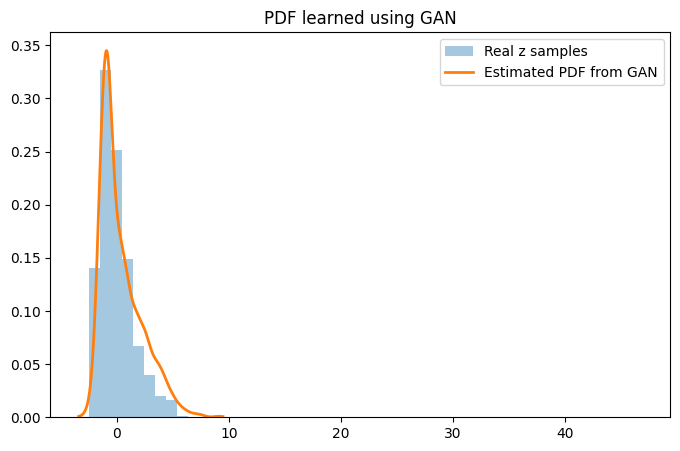

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import gaussian_kde

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("/content/data.csv", encoding="latin1")
x = df["no2"].dropna().values
x = (x - np.mean(x)) / np.std(x)

r = 102303561
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)

z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1,1)
z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

noise_dim = 10

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)

epochs = 2000
batch_size = 64

for epoch in range(epochs):

    idx = np.random.randint(0, z_tensor.shape[0], batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    optimizer_D.zero_grad()

    outputs_real = D(real_samples)
    loss_real = criterion(outputs_real, real_labels)

    noise = torch.randn(batch_size, noise_dim).to(device)
    fake_samples = G(noise)

    outputs_fake = D(fake_samples.detach())
    loss_fake = criterion(outputs_fake, fake_labels)

    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()

    outputs = D(fake_samples)
    loss_G = criterion(outputs, real_labels)

    loss_G.backward()
    optimizer_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

with torch.no_grad():
    noise = torch.randn(5000, noise_dim).to(device)
    z_fake = G(noise).cpu().numpy().flatten()

kde = gaussian_kde(z_fake)

xs = np.linspace(min(z_fake), max(z_fake), 1000)
pdf = kde(xs)

plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real z samples")
plt.plot(xs, pdf, label="Estimated PDF from GAN", linewidth=2)
plt.legend()
plt.title("PDF learned using GAN")
plt.show()

In [15]:
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'data.csv', 'sample_data']


In [19]:
print(df.columns)

Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


In [20]:
plt.savefig("pdf_plot.png")

<Figure size 640x480 with 0 Axes>